In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.utils.image_utils import remap_on_new_mask
from ekarus.analytical.zernike_generator import ZernikeGenerator

import ekarus.e2e.utils.my_fits_package as my_fits

from scipy.interpolate import Rbf

from numpy.ma import masked_array
from ekarus.e2e.utils.image_utils import reshape_on_mask


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def create_field_from_zernike_coefficients(mask, noll_ids, amplitudes):
    """
    Create an electric field input corresponding to a Zernike aberration.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: input electric field as a numpy complex array
    """
    phase_mask = project_zernike_on_mask(mask, noll_ids, amplitudes)
    return (1-mask) * xp.exp(1j * phase_mask)


def project_zernike_on_mask(mask, noll_ids, amplitudes):
    """
    Create a linear combination of Zernikes on a mask.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: zernike combination
    """
    mask_size = max(mask.shape)
    zg = ZernikeGenerator(xp.asnumpy(mask),mask_size//2)

    if isinstance(noll_ids,int):
        amp = amplitudes
        noll = noll_ids
        zern = amp * xp.asarray(zg.getZernike(int(noll)))
    else:
        amplitudes *= xp.ones_like(noll_ids)
        zern = xp.zeros(mask.shape)
        for amp,noll in zip(amplitudes, noll_ids):
            zern += amp * xp.asarray(zg.getZernike(int(noll)))

    return zern

# def get_tikhonov_rec(KL, m2c, visible_ids, gamma:float=1e-4, modal:bool=False):
#     IM = KL.T @ xp.linalg.pinv(m2c) #m2c @ xp.linalg.pinv(KL.T)
#     IMm = IM[visible_ids,:]
#     U,S,V = xp.linalg.svd(IMm,full_matrices=False)
#     Sinv = 1/S
#     LAMBDA = S**2/(gamma+S**2) * Sinv
#     LAMBDA[S/max(S)>gamma] = Sinv[S/max(S)>gamma]
#     newRec = (V.T * LAMBDA) @ U.T
#     if modal:
#         newRec = xp.linalg.pinv(m2c) @ newRec
#     return newRec

def get_tikhonov_rec(IF, gamma:float=1e-4):
    U,S,V = xp.linalg.svd(IF,full_matrices=False)
    # Sinv = 1/S
    LAMBDA = S/(gamma*(S/max(S)<=gamma)+S**2)
    # LAMBDA[S/max(S)>gamma] = Sinv[S/max(S)>gamma]
    newRec = (V.T * LAMBDA) @ U.T
    return newRec

In [3]:
def specula_slaving(cmask,coordinates,n_act:int=32,dim:int=128,slaving_thr:float=0.2):
    idx = xp.where(1-cmask)
    step = dim/n_act

    # x, y = xp.meshgrid(xp.linspace(0, dim, n_act), xp.linspace(0, dim, n_act))
    # x, y = x.ravel(), y.ravel()
    # x_c, y_c = dim / 2, dim / 2 # center
    # rho = xp.sqrt((x-x_c)**2+(y-y_c)**2)
    # rho_max = (dim*(9/8-n_act/(24*16)))/2 # slightly larger than dim, depends on n_act
    # x = x[rho<=rho_max]
    # y = y[rho<=rho_max]
    # n_act_tot = int(xp.size(x))
    # coordinates = xp.vstack((x,y))
    x,y = coordinates
    n_act_tot = xp.shape(coordinates)[1]
    grid_x, grid_y = xp.meshgrid(xp.arange(dim), xp.arange(dim))

    ifs_cube = xp.zeros((n_act_tot, dim, dim), dtype=xp.float)

    # Minimum distance between points
    min_distance_norm = 9*step

    for i in range(n_act_tot):
        z = xp.zeros(n_act_tot, dtype=xp.float)
        z[i] = 1.0  # Set the central actuator
        if min_distance_norm >= dim/2:
            x_close, y_close, z_close = x, y, z
            idx_far_grid = None
        else:
            distance = xp.sqrt((x - x[i]) ** 2 + (y - y[i]) ** 2)
            idx_close = xp.where(distance <= min_distance_norm)[0]
            x_close, y_close, z_close = x[idx_close], y[idx_close], z[idx_close]           
            # Compute the distance grid
            distance_grid = xp.sqrt((grid_x.ravel() - x[i]) ** 2 + (grid_y.ravel() - y[i]) ** 2)
            idx_far_grid = xp.where(distance_grid > 0.8*min_distance_norm)[0]
        # Convert to NumPy arrays for Rbf interpolation (required)
        x_close_np = xp.asnumpy(x_close)
        y_close_np = xp.asnumpy(y_close)
        z_close_np = xp.asnumpy(z_close)
        grid_x_np = xp.asnumpy(grid_x)
        grid_y_np = xp.asnumpy(grid_y)
        # Interpolation using Thin Plate Splines (using NumPy arrays)
        rbf = Rbf(x_close_np, y_close_np, z_close_np, function='thin_plate')
        # Perform interpolation
        z_interp_np = rbf(grid_x_np, grid_y_np)
        # Convert back to xp array
        z_interp = xp.asarray(z_interp_np)
        if idx_far_grid is not None:
            z_interp.ravel()[idx_far_grid] = 0
        ifs_cube[i, :, :] = z_interp
    
    max_vals = xp.max(ifs_cube[:, idx[0], idx[1]], axis=1)
    max_vals_all = xp.max(ifs_cube, axis=(1, 2))
    idx_master = xp.where(max_vals >= slaving_thr * max_vals_all)[0]
    idx_slave = xp.where(max_vals < slaving_thr * max_vals_all)[0]

    print(f"Actuators: {n_act_tot}")
    print(f"Master actuators: {len(idx_master)}")
    print(f"Actuators to be slaved: {len(idx_slave)}")

    plt.figure()
    plt.imshow(xp.asnumpy(cmask),origin='lower',cmap='grey')
    plt.scatter(xp.asnumpy(x),xp.asnumpy(y),c='green',label='masters')
    plt.scatter(xp.asnumpy(x[idx_slave]),xp.asnumpy(y[idx_slave]),c='red',label='slaves')
    plt.legend()
    plt.grid()

    slaveMat1 = xp.zeros((n_act_tot, n_act_tot), dtype=xp.float)

    for i in range(n_act_tot):
        if i in idx_master:
            distance = xp.sqrt((coordinates[0] - coordinates[0][i])**2 + 
                            (coordinates[1] - coordinates[1][i])**2)

            idx_close_master1 = xp.where(distance <= 1.1 * step)[0]
            idx_close_master1 = xp.intersect1d(idx_close_master1, idx_slave)

            if len(idx_close_master1) > 0:
                for j in idx_close_master1:
                    slaveMat1[i, j] = 1.0

    for j in range(n_act_tot):
        slaveMat1[:, j] *= 1.0 / max(1.0, xp.sum(slaveMat1[:, j]))

    for i in range(n_act_tot):
        if xp.sum(slaveMat1[i, :]) > 0:
            idx_temp = xp.where(slaveMat1[i, :] > 0)[0]
            for j in idx_temp:
                ifs_cube[i] += slaveMat1[i, j] * ifs_cube[j]

    aux = slaveMat1.copy()
    for i in range(n_act_tot):
        if i in idx_master:
            aux[i,i] = 1.0
    m2c = aux[idx_master,:]#xp.linalg.pinv(slaveMat1[idx_master,:])

    ifs_cube = ifs_cube[idx_master]
    n_act_tot = len(idx_master)

    ifs_2d = xp.array([ifs_cube[i][idx] for i in range(n_act_tot)], dtype=xp.float)

    return ifs_2d.T, m2c.T

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Fried parameter is: 5.0 [cm] (seeing = 2.02")


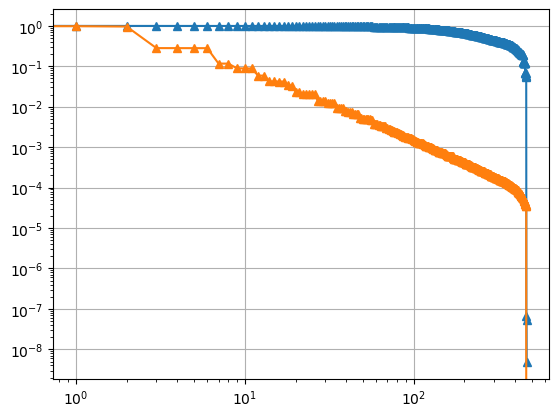

In [4]:
ssao = SingleStageAO(tn='master_DM468')
ssao.initialize_turbulence()
KL, m2c, iffs_sv, modes_sv = ssao.define_KL_modes(ssao.dm, zern_modes=2, return_sv=True)

plt.figure()
plt.plot(xp.asnumpy(iffs_sv/max(iffs_sv)),'-^')
plt.plot(xp.asnumpy(modes_sv/max(modes_sv)),'-^')
plt.grid()
plt.xscale('log')
plt.yscale('log')

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Unobscured actuators: 436/468


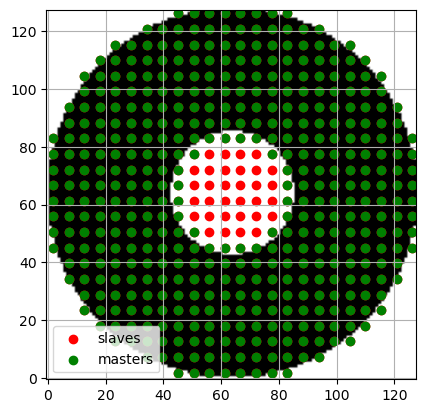

In [5]:
slav_ssao = SingleStageAO(tn='slaving_DM468')
sKL, sm2c = slav_ssao.define_KL_modes(slav_ssao.dm, zern_modes=2)

In [6]:
import os.path as op
filename = op.join(ssao.savecalibpath,'specula_iffs.fits')
m2c_filename = op.join(ssao.savecalibpath,'specula_m2c.fits')

try:
    specula_IFFs = my_fits.read_fits(filename)
    specula_m2c = my_fits.read_fits(m2c_filename)
except FileNotFoundError:
    specula_IFFs, specula_m2c = specula_slaving(slav_ssao.cmask, ssao.dm.act_coords.copy(), slaving_thr=0.1)
    my_fits.save_fits(filename, specula_IFFs)
    my_fits.save_fits(m2c_filename, specula_m2c)

In [7]:
print(ssao.dm.IFF.shape, specula_IFFs.shape, xp.sum(1-slav_ssao.cmask), slav_ssao.dm.slaving.shape)

(12849, 468) (11416, 436) 11416 (468, 436)


In [8]:
fa_IFFs = ssao.dm.IFF
visible_IFFs = ssao.dm.IFF[slav_ssao.dm.visible_pix_ids,:]
crop_IFFs = visible_IFFs[:,slav_ssao.dm.master_ids]

fa_Rec = xp.linalg.pinv(fa_IFFs)
crop_Rec = xp.linalg.pinv(crop_IFFs)
visible_Rec = xp.linalg.pinv(visible_IFFs)
specula_Rec = xp.linalg.pinv(specula_IFFs)
ticho_Rec = get_tikhonov_rec(visible_IFFs, gamma=0.02)

def get_rms_res_and_cmd(phase, IF, Rec, slaving=None, remap:bool=False):
    cmd = Rec @ phase
    if slaving is not None:
        cmd = slaving @ cmd
    rec_phase = IF @ cmd
    res_phase = phase - rec_phase
    if remap is True:
        phase_2d = reshape_on_mask(res_phase, ssao.cmask)
        res_phase = phase_2d[~slav_ssao.cmask]
    phi_rms = xp.sqrt(xp.sum((res_phase-xp.mean(res_phase))**2)/len(res_phase))
    cmd_rms = xp.sqrt(xp.sum(cmd**2)/len(cmd))
    max_cmd = xp.max(abs(cmd))
    return phi_rms, cmd_rms, max_cmd

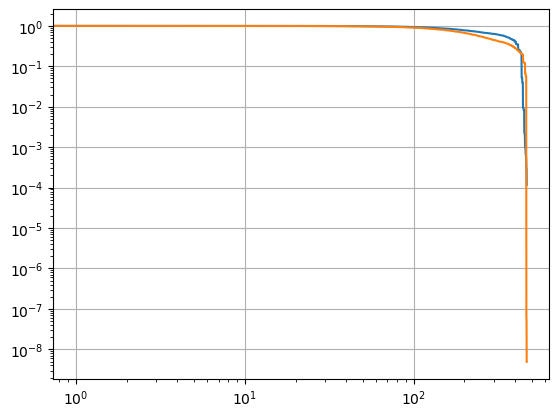

In [9]:
_,D,_ = xp.linalg.svd(visible_IFFs,full_matrices=False)

plt.figure()
plt.plot(xp.asnumpy(D/max(D)))
plt.plot(xp.asnumpy(iffs_sv/max(iffs_sv)))
plt.grid()
plt.xscale('log')
plt.yscale('log')

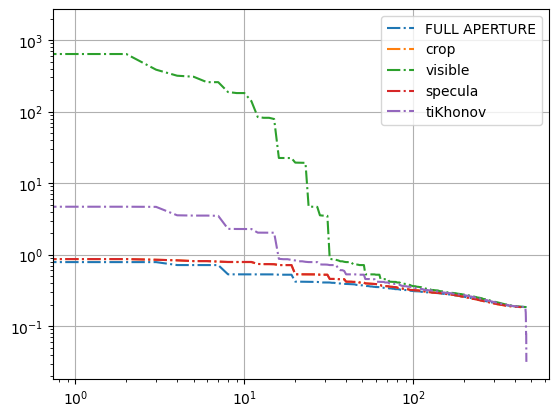

In [10]:
_,fa_D,_ = xp.linalg.svd(fa_Rec,full_matrices=False)
_,crop_D,_ = xp.linalg.svd(crop_Rec,full_matrices=False)
_,vis_D,_ = xp.linalg.svd(visible_Rec,full_matrices=False)
_,spe_D,_ = xp.linalg.svd(specula_Rec,full_matrices=False)
_,ticho_D,_ = xp.linalg.svd(ticho_Rec,full_matrices=False)

plt.figure()
plt.plot(xp.asnumpy(fa_D),'-.',label='FULL APERTURE')
plt.plot(xp.asnumpy(crop_D),'-.',label='crop')
plt.plot(xp.asnumpy(vis_D),'-.',label='visible')
plt.plot(xp.asnumpy(spe_D),'-.',label='specula')
plt.plot(xp.asnumpy(ticho_D),'-.',label='tiKhonov')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')

In [11]:
N = 600

phase_rms = xp.zeros(N)

fa_rms = xp.zeros(N) # FULL APERTURE
crop_rms = xp.zeros(N) # cropping IFFs
mean_rms = xp.zeros(N) # mean slaving
ticho_rms = xp.zeros(N) # tikhonov regularization
specula_rms = xp.zeros(N) # ADDing slave IFFs to masters'

fa_cmd_rms = xp.zeros(N) # FULL APERTURE
crop_cmd_rms = xp.zeros(N) # cropping IFFs
mean_cmd_rms = xp.zeros(N) # mean slaving
ticho_cmd_rms = xp.zeros(N) # tikhonov regularization
specula_cmd_rms = xp.zeros(N) # ADDing slave IFFs to masters'

fa_max_cmd = xp.zeros(N) # FULL APERTURE
crop_max_cmd = xp.zeros(N) # cropping IFFs
mean_max_cmd = xp.zeros(N) # mean slaving
ticho_max_cmd = xp.zeros(N) # tikhonov regularization
specula_max_cmd = xp.zeros(N) # ADDing slave IFFs to masters'

for jj in range(N):
    atmo_phase = ssao.get_phasescreen_at_time(jj*ssao.dt*2)
    fa_phase = atmo_phase[~ssao.cmask]
    phase = atmo_phase[~slav_ssao.cmask]

    fa_phase -= xp.mean(fa_phase)
    phase -= xp.mean(phase)

    phase_rms[jj] = xp.sqrt(xp.sum(phase**2))/len(phase)

    # FULL APERTURE
    fa_rms[jj], fa_cmd_rms[jj], fa_max_cmd[jj] = get_rms_res_and_cmd(fa_phase, fa_IFFs, fa_Rec, remap=True)

    # Crop
    crop_rms[jj], crop_cmd_rms[jj], crop_max_cmd[jj] = get_rms_res_and_cmd(phase, crop_IFFs, crop_Rec)

    # mean
    mean_rms[jj], mean_cmd_rms[jj], mean_max_cmd[jj] = get_rms_res_and_cmd(phase, visible_IFFs, crop_Rec, slav_ssao.dm.slaving)

    # specula
    specula_rms[jj], specula_cmd_rms[jj], specula_max_cmd[jj] = get_rms_res_and_cmd(phase, specula_IFFs, specula_Rec)

    # tikhonov
    ticho_rms[jj], ticho_cmd_rms[jj], ticho_max_cmd[jj] = get_rms_res_and_cmd(phase, visible_IFFs, ticho_Rec)


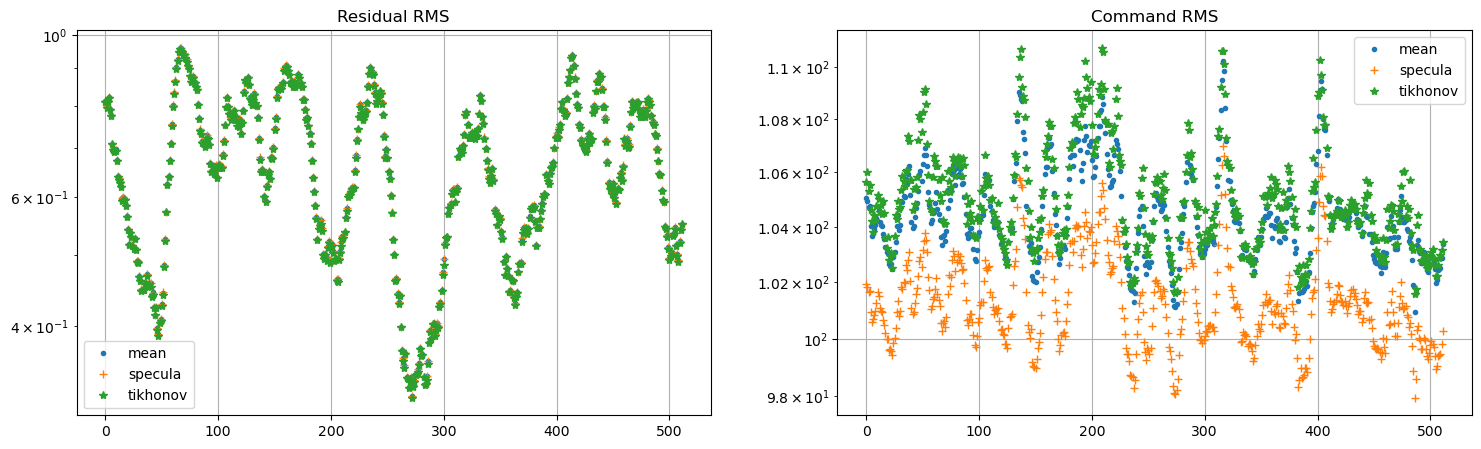

: 

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(crop_rms/fa_rms),'.',label='mean')
plt.plot(xp.asnumpy(specula_rms/fa_rms),'+',label='specula')
plt.plot(xp.asnumpy(ticho_rms/fa_rms),'*',label='tikhonov')
plt.legend()
plt.title('Residual RMS')
plt.yscale('log')
plt.grid()
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(crop_cmd_rms/phase_rms),'.',label='mean')
plt.plot(xp.asnumpy(specula_cmd_rms/phase_rms*768/820),'+',label='specula')
plt.plot(xp.asnumpy(ticho_cmd_rms/phase_rms),'*',label='tikhonov')
plt.legend()
plt.title('Command RMS')
plt.yscale('log')
plt.grid()
# plt.subplot(2,2,3)
# plt.plot(xp.asnumpy(mean_rms/crop_rms),label='mean')
# plt.plot(xp.asnumpy(specula_rms/crop_rms),label='specula')
# plt.plot(xp.asnumpy(ticho_rms/crop_rms),label='tikhonov')
# plt.legend()
# plt.title('Residual RMS')
# plt.yscale('log')
# plt.grid()
# plt.subplot(2,2,4)
# plt.plot(xp.asnumpy(mean_cmd_rms),label='mean')
# plt.plot(xp.asnumpy(specula_cmd_rms),label='specula')
# plt.plot(xp.asnumpy(ticho_cmd_rms),label='tikhonov')
# plt.legend()
# plt.title('Command RMS')
# plt.yscale('log')
# plt.grid()

In [13]:
print(xp.sum(crop_rms), xp.sum(crop_cmd_rms))
print(xp.sum(mean_rms), xp.sum(mean_cmd_rms))
print(xp.sum(ticho_rms), xp.sum(ticho_cmd_rms))
print(xp.sum(specula_rms), xp.sum(specula_cmd_rms*768/820))

2.8808015216613796e-05 0.0006070874530998694
2.8808015216613796e-05 0.0005859648639777791
2.8625836698211188e-05 0.000590470797888702
2.881203535800636e-05 0.00056848608884346


(np.float64(-4.444444444444445),
 np.float64(132.44444444444446),
 np.float64(-4.444444444444445),
 np.float64(132.44444444444446))

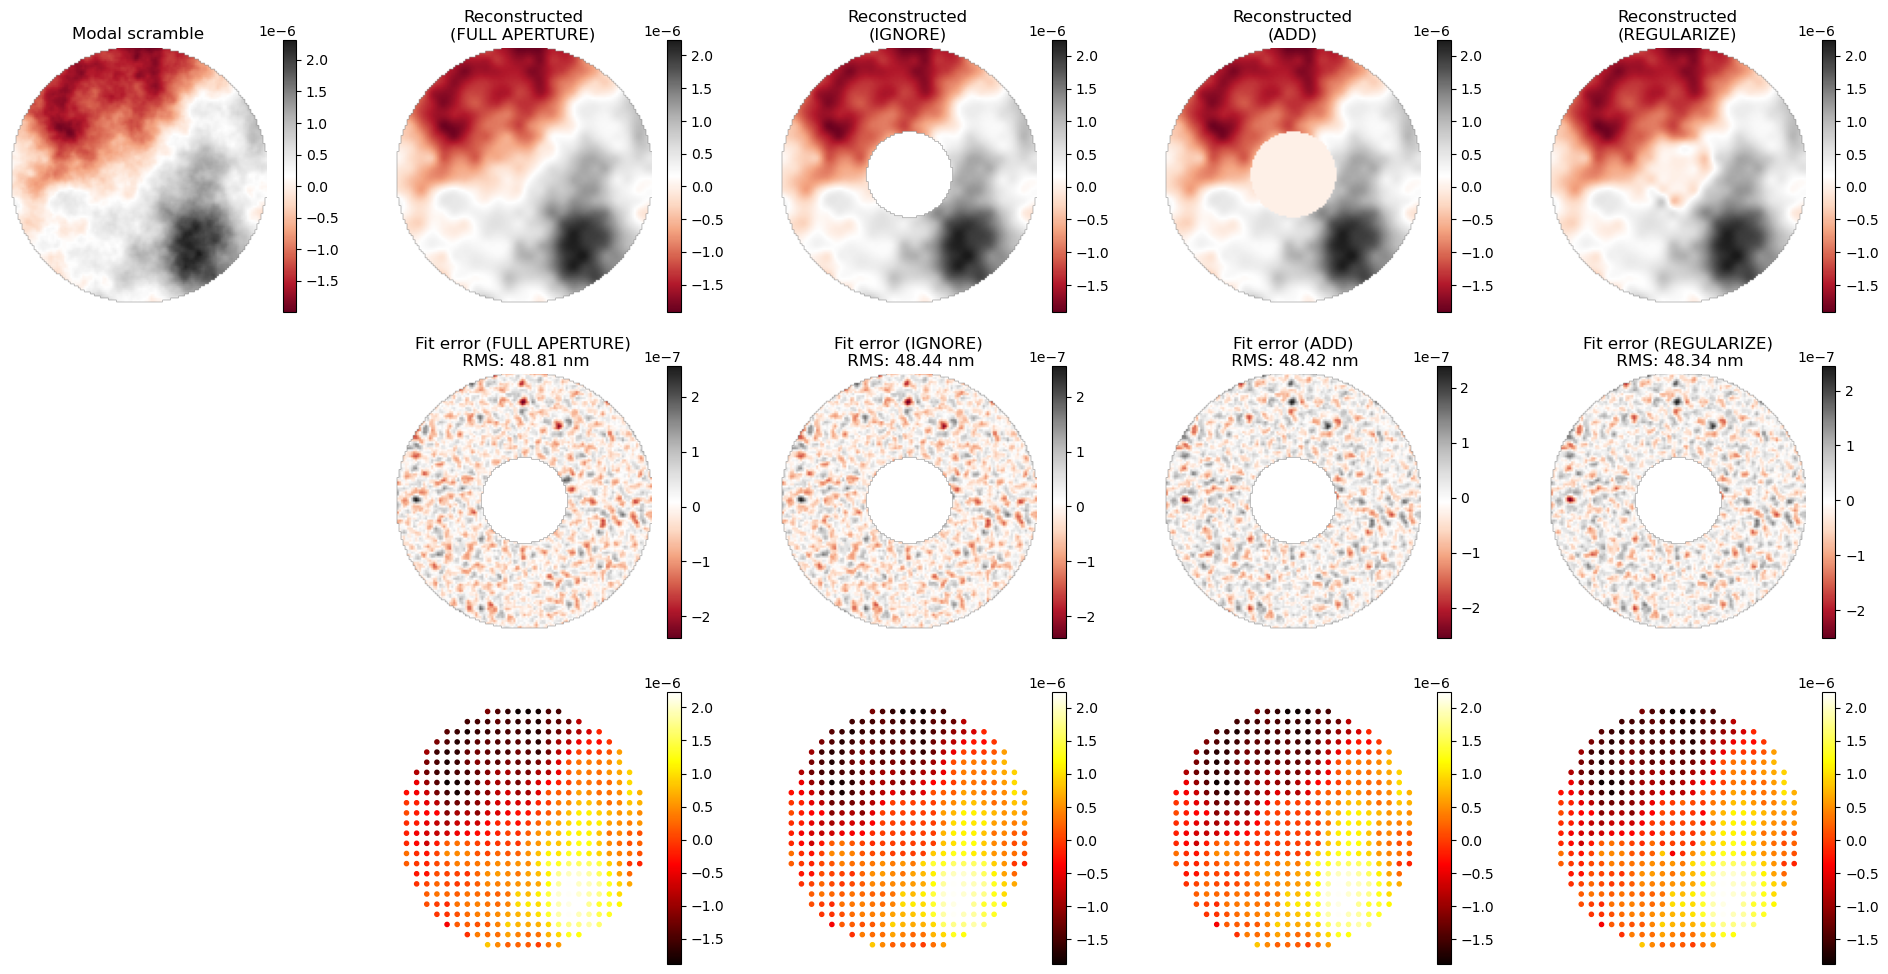

In [14]:


atmo_phase = ssao.get_phasescreen_at_time(2)
fa_phase = atmo_phase[~ssao.cmask]
phase = atmo_phase[~slav_ssao.cmask]

fa_phase -= xp.mean(fa_phase)
phase -= xp.mean(phase)

# FULL APERTURE
fa_cmd = fa_Rec @ fa_phase
rec_phase = fa_IFFs @ fa_cmd

# crop
crop_cmd = crop_Rec @ phase
crop_rec_phase = crop_IFFs @ crop_cmd

# specula
spe_cmd = specula_Rec @ phase
spe_rec_phase = specula_IFFs @ spe_cmd


# tikhonov
tic_cmd = ticho_Rec @ phase
tic_rec_phase = fa_IFFs @ tic_cmd


phase = reshape_on_mask(phase, slav_ssao.cmask)
fa_phase = reshape_on_mask(fa_phase, ssao.cmask)
crop_rec_phase = reshape_on_mask(crop_rec_phase, slav_ssao.cmask)
spe_rec_phase = reshape_on_mask(spe_rec_phase, slav_ssao.cmask)
tic_rec_phase = reshape_on_mask(tic_rec_phase, ssao.cmask)
rec_phase = reshape_on_mask(rec_phase, ssao.cmask)

plt.figure(figsize=(24,12))
plt.subplot(3,5,1)
plt.imshow(masked_array(xp.asnumpy(fa_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title('Modal scramble')
plt.subplot(3,5,2)
plt.imshow(masked_array(xp.asnumpy(rec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed\n(FULL APERTURE)')
plt.subplot(3,5,3)
plt.imshow(masked_array(xp.asnumpy(crop_rec_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed\n(IGNORE)')
plt.subplot(3,5,7)
plt.imshow(masked_array(xp.asnumpy(fa_phase-rec_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title(f'Fit error (FULL APERTURE)\n RMS: {xp.std(rec_phase[~slav_ssao.cmask]-fa_phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
# plt.title(f'Fit error (FULL APERTURE)\n RMS: {xp.sqrt(xp.sum((fa_phase[~slav_ssao.cmask]-rec_phase[~slav_ssao.cmask])**2))/len(phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
plt.subplot(3,5,8)
plt.imshow(masked_array(xp.asnumpy(phase-crop_rec_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title(f'Fit error (IGNORE)\n RMS: {xp.std(crop_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
# plt.title(f'Fit error (IGNORE)\n RMS: {xp.sqrt(xp.sum((cut_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])**2))/len(phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
plt.subplot(3,5,4)
plt.imshow(masked_array(xp.asnumpy(spe_rec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed\n(ADD)')
plt.subplot(3,5,9)
plt.imshow(masked_array(xp.asnumpy(spe_rec_phase-phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title(f'Fit error (ADD)\n RMS: {xp.std(spe_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
# plt.title(f'Fit error (ADD)\n RMS: {xp.sqrt(xp.sum((spe_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])**2))/len(phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
plt.subplot(3,5,5)
plt.imshow(masked_array(xp.asnumpy(tic_rec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed\n(REGULARIZE)')
plt.subplot(3,5,10)
plt.imshow(masked_array(xp.asnumpy(tic_rec_phase-fa_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title(f'Fit error (REGULARIZE)\n RMS: {xp.std(tic_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
# plt.title(f'Fit error (REGULARIZE)\n RMS: {xp.sqrt(xp.sum((tic_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])**2))/len(phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
plt.subplot(3,5,12)
ssao.dm.plot_position(fa_cmd)
plt.axis('off')
plt.subplot(3,5,13)
ssao.dm.plot_position(slav_ssao.dm.slaving @ crop_cmd)
plt.axis('off')
plt.subplot(3,5,14)
ssao.dm.plot_position(xp.dot(spe_cmd,specula_m2c.T),transpose=False)
plt.axis('off')
plt.subplot(3,5,15)
ssao.dm.plot_position(tic_cmd)
plt.axis('off')

In [15]:
spe_dm = slav_ssao.dm
spe_dm.IFF = specula_IFFs
spe_dm.mask = spe_dm.pupil_mask
mat_slaving = spe_dm.slaving.copy()
spe_dm.slaving = None
speKL, spe_m2c = slav_ssao.define_KL_modes(slav_ssao.dm, zern_modes=2, save_prefix='specula_')

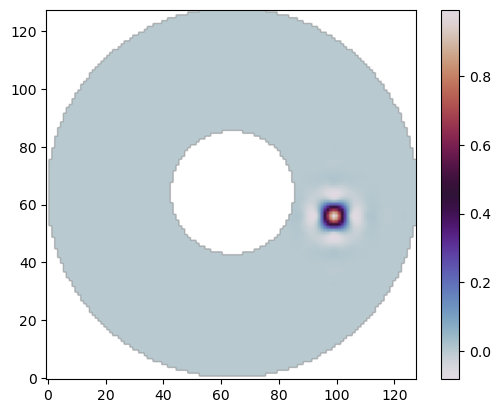

In [16]:
shape = xp.zeros([128,128])
shape[~spe_dm.mask] = specula_IFFs[:,194]
shape = (shape).reshape([128,128])

plt.figure()
plt.imshow(masked_array(xp.asnumpy(shape),mask=xp.asnumpy(spe_dm.mask)),origin='lower',cmap='twilight')
plt.colorbar()

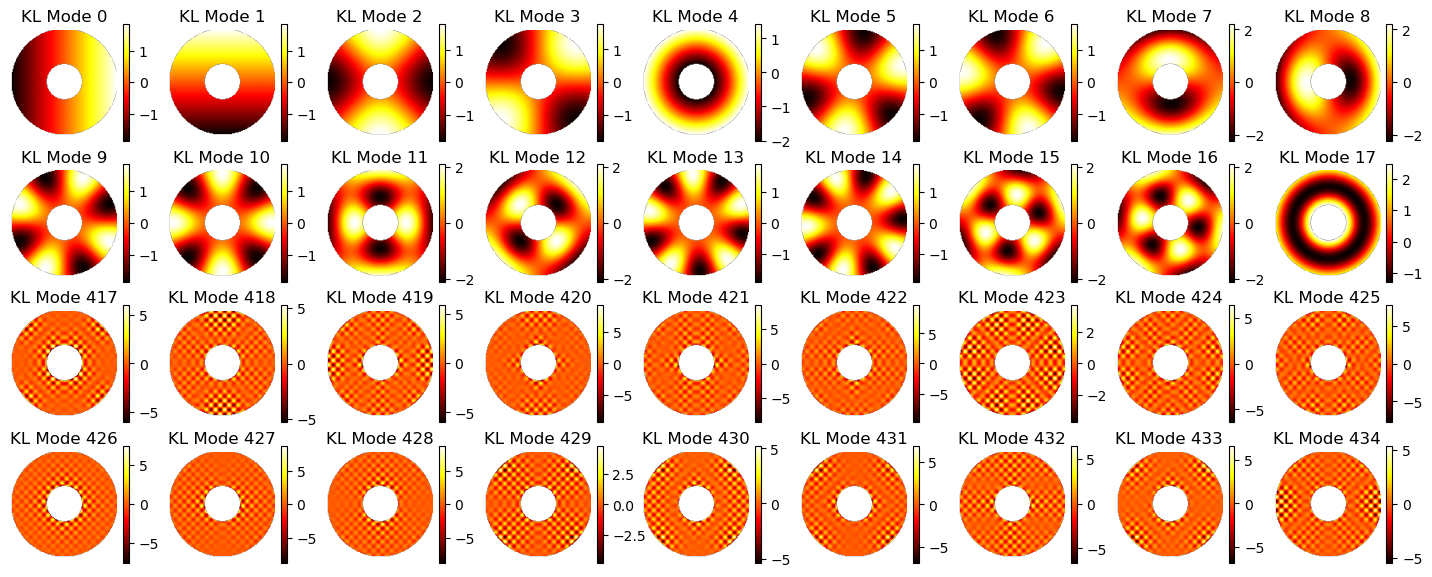

In [17]:
N=9
plt.figure(figsize=(2*N,7))
for i in range(N):
    plt.subplot(4,N,i+1)
    spe_dm.plot_surface(speKL[i,:],title=f'KL Mode {i}')
    plt.subplot(4,N,i+1+N)
    spe_dm.plot_surface(speKL[i+N,:],title=f'KL Mode {i+N}')
    plt.subplot(4,N,i+1+N*2)
    spe_dm.plot_surface(speKL[-i-1-N,:],title=f'KL Mode {xp.shape(speKL)[0]-2*N+i}')
    plt.subplot(4,N,i+1+N*3)
    spe_dm.plot_surface(speKL[-i-1,:],title=f'KL Mode {xp.shape(speKL)[0]-N+i}')

In [18]:
cutKL = remap_on_new_mask(KL, ssao.dm.mask, slav_ssao.dm.pupil_mask)

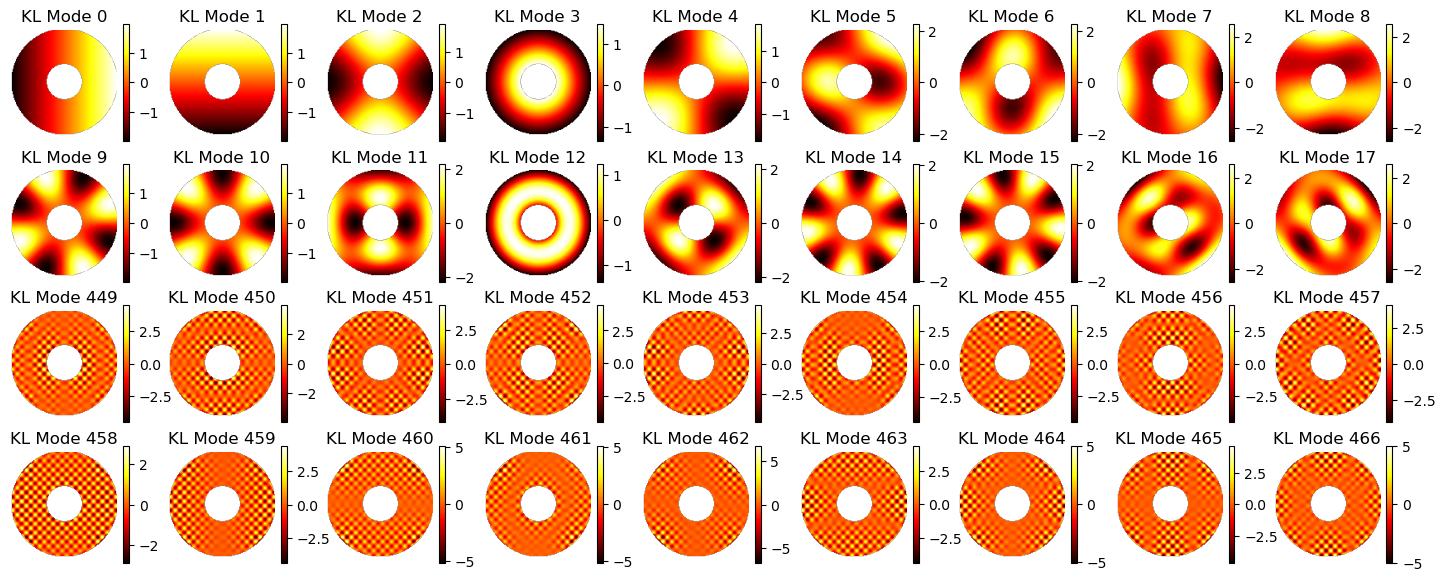

In [19]:
N=9
plt.figure(figsize=(2*N,7))
for i in range(N):
    plt.subplot(4,N,i+1)
    spe_dm.plot_surface(cutKL[i,:],title=f'KL Mode {i}')
    plt.subplot(4,N,i+1+N)
    spe_dm.plot_surface(cutKL[i+N,:],title=f'KL Mode {i+N}')
    plt.subplot(4,N,i+1+N*2)
    spe_dm.plot_surface(cutKL[-i-1-N,:],title=f'KL Mode {xp.shape(cutKL)[0]-2*N+i}')
    plt.subplot(4,N,i+1+N*3)
    spe_dm.plot_surface(cutKL[-i-1,:],title=f'KL Mode {xp.shape(cutKL)[0]-N+i}')

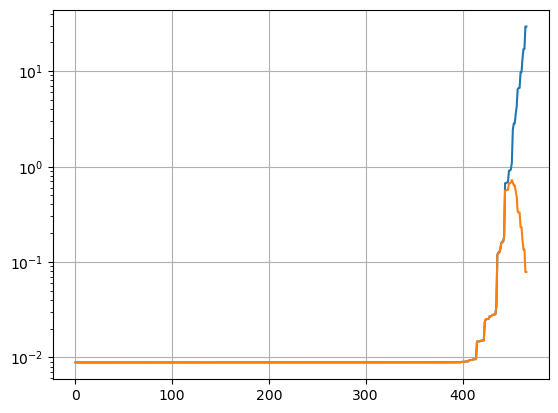

In [20]:
Rec = xp.linalg.pinv(KL.T)
speRec = xp.linalg.pinv(speKL.T)
cutRec = xp.linalg.pinv(cutKL.T)
sRec = xp.linalg.pinv(sKL.T)

U,D,V = xp.linalg.svd(cutKL.T,full_matrices=False)

gamma = (24/128)#**2
Dreg = D/(D**2+xp.sqrt(gamma)*(D/max(D)<=gamma))
# thr = 100
# pen = 0.1**2
# Dreg = D/(D**2+pen*(D/max(D)<=thr))
tichoRec = (V.T * Dreg) @ U.T


plt.figure()
plt.plot(xp.asnumpy(1/D))
plt.plot(xp.asnumpy(Dreg))
plt.yscale('log')
plt.grid()

0.03515625


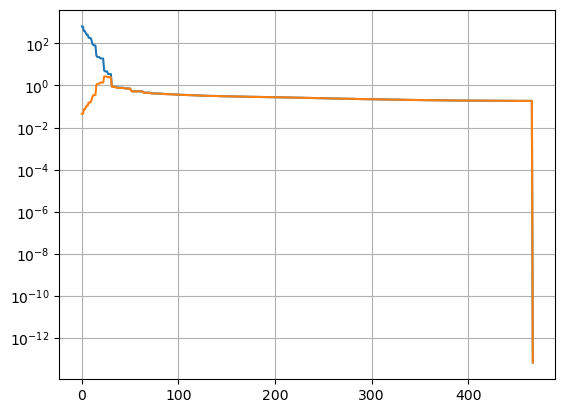

In [21]:
s2c = m2c @ cutRec
U,D,V = xp.linalg.svd(s2c,full_matrices=False)

gamma = (24/128)**2
Dinv = 1/D
# Dreg = 1/(Dinv+gamma*(Dinv<gamma))
# Dreg = 1/(Dinv+gamma*(Dinv/max(Dinv)<gamma))
# Dreg = Dinv / (Dinv**2 + gamma)
Dreg = Dinv / (Dinv**2 + gamma*(Dinv/max(Dinv)<gamma))
print(gamma)

plt.figure()
plt.plot(xp.asnumpy(D))
plt.plot(xp.asnumpy(Dreg))
plt.yscale('log')
plt.grid()

new_s2c = (U*Dreg) @ V

In [22]:
# ids = xp.arange(int(xp.sum(1-ssao.cmask)))
# ids_2d = xp.zeros(ssao.cmask.shape)
# ids_2d[~ssao.cmask] = ids
# ids_2d = xp.reshape(ids_2d, ssao.cmask.shape)
# master_pix_ids = xp.asarray(ids_2d[~slav_ssao.cmask],dtype=int)
# slave_pix_ids = xp.asarray(ids_2d[xp.logical_and(slav_ssao.cmask,~ssao.cmask)],dtype=int)

# # plt.figure()
# # plt.imshow(xp.asnumpy(ids_2d))

In [23]:
# master_amp = 1e-9
# slave_amp = 1e-7
# pp = xp.ones(len(ids))*master_amp
# pp[slave_pix_ids] = slave_amp

# Q = xp.diag(1/modes_sv[:-1])
# P = xp.diag(pp)


# aux = Rec.T @ Q
# temp = aux @ Rec + P
# new_s2c = xp.linalg.inv(temp) @ aux

# _,D,_ = xp.linalg.svd(new_s2c,full_matrices=False)
# plt.figure()
# plt.plot(xp.asnumpy(D))
# plt.yscale('log')
# plt.grid()

In [24]:
IGNORE_slaving = xp.zeros([ssao.dm.Nacts,len(slav_ssao.dm.master_ids)])
for i,master in enumerate(slav_ssao.dm.master_ids):
    IGNORE_slaving[master,i] = 1.0

print(sRec.shape, sm2c.shape)
slave_ids = xp.ones(ssao.dm.Nacts,dtype=bool)
slave_ids[slav_ssao.dm.master_ids] = 0

(435, 11416) (436, 435)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
1.519554551486341e-22 2.9050889472703575e-08 3.026293176970972e-08 6.714805535844938e-09 2.380122466051375e-08


(np.float64(-4.444444444444445),
 np.float64(132.44444444444446),
 np.float64(-4.444444444444445),
 np.float64(132.44444444444446))

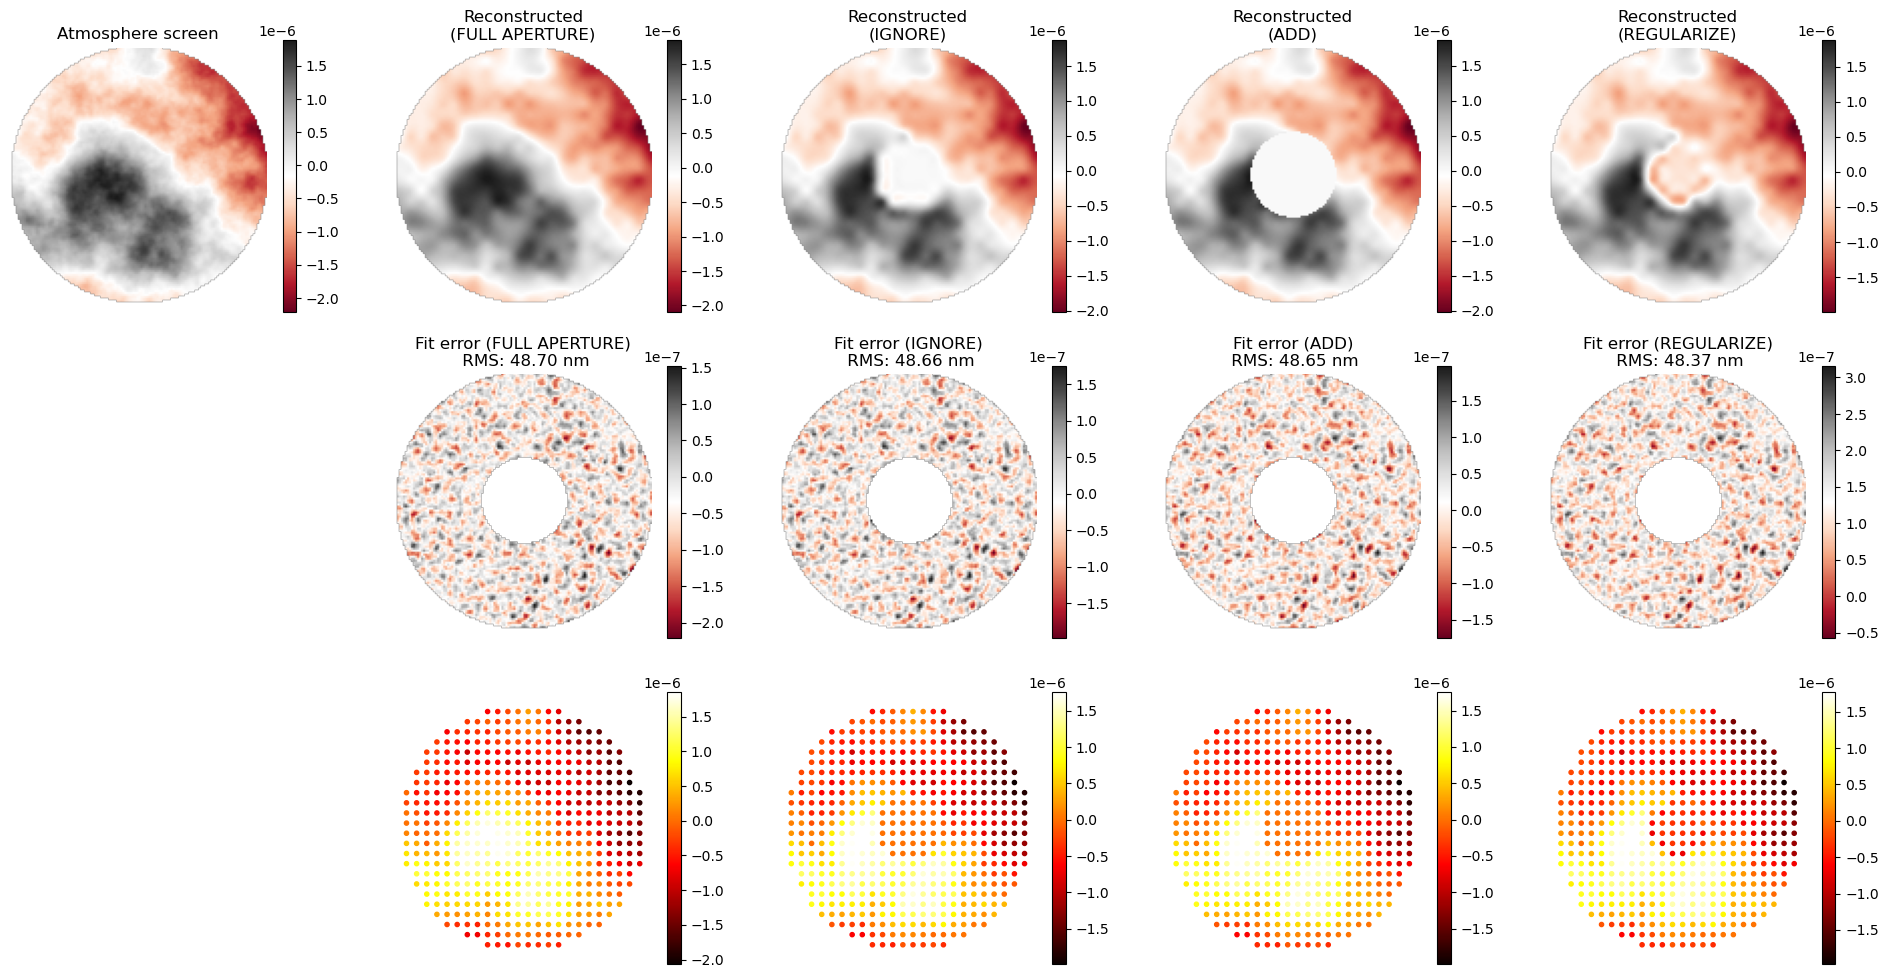

In [25]:
atmo_phase = ssao.get_phasescreen_at_time(0.4)
fa_phase = atmo_phase[~ssao.cmask]
phase = atmo_phase[~slav_ssao.cmask]

fa_phase -= xp.mean(fa_phase)
phase -= xp.mean(phase)

# FULL APERTURE
fa_mode = Rec @ fa_phase
fa_cmd = m2c @ fa_mode
# fa_cmd = s2c @ phase
rec_phase = fa_IFFs @ fa_cmd

# crop
# cut_mode = cutRec @ phase
# cut_cmd = m2c @ cut_mode
# cut_rec_phase = fa_IFFs @ cut_cmd
cut_mode = sRec @ phase
cut_cmd = sm2c @ cut_mode
cut_cmd =  IGNORE_slaving @ cut_cmd #mat_slaving @ cut_cmd #
cut_rec_phase = fa_IFFs @ cut_cmd

print(cut_cmd[slave_ids])


# specula
spe_mode = speRec @ phase
spe_cmd = spe_m2c @ spe_mode
spe_rec_phase = specula_IFFs @ spe_cmd
# spe_cmd = xp.dot(spe_cmd,specula_m2c.T)
# spe_rec_phase = fa_IFFs @ spe_cmd


# tikhonov
# tic_mode = tichoRec @ phase
# tic_cmd = m2c @ tic_mode
tic_cmd = new_s2c @ phase
tic_rec_phase = fa_IFFs @ tic_cmd

print(xp.mean(phase),xp.mean(cut_rec_phase),xp.mean(rec_phase),xp.mean(spe_rec_phase),xp.mean(tic_rec_phase))


phase = reshape_on_mask(phase, slav_ssao.cmask)
fa_phase = reshape_on_mask(fa_phase, ssao.cmask)
cut_rec_phase = reshape_on_mask(cut_rec_phase, ssao.cmask)
spe_rec_phase = reshape_on_mask(spe_rec_phase, slav_ssao.cmask)
tic_rec_phase = reshape_on_mask(tic_rec_phase, ssao.cmask)
rec_phase = reshape_on_mask(rec_phase, ssao.cmask)

plt.figure(figsize=(24,12))
plt.subplot(3,5,1)
plt.imshow(masked_array(xp.asnumpy(fa_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title('Atmosphere screen')
plt.subplot(3,5,2)
plt.imshow(masked_array(xp.asnumpy(rec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed\n(FULL APERTURE)')
plt.subplot(3,5,3)
plt.imshow(masked_array(xp.asnumpy(cut_rec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed\n(IGNORE)')
plt.subplot(3,5,7)
plt.imshow(masked_array(xp.asnumpy(fa_phase-rec_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title(f'Fit error (FULL APERTURE)\n RMS: {xp.std(rec_phase[~slav_ssao.cmask]-fa_phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
# plt.title(f'Fit error (FULL APERTURE)\n RMS: {xp.sqrt(xp.sum((fa_phase[~slav_ssao.cmask]-rec_phase[~slav_ssao.cmask])**2))/len(phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
plt.subplot(3,5,8)
plt.imshow(masked_array(xp.asnumpy(phase-cut_rec_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title(f'Fit error (IGNORE)\n RMS: {xp.std(cut_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
# plt.title(f'Fit error (IGNORE)\n RMS: {xp.sqrt(xp.sum((cut_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])**2))/len(phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
plt.subplot(3,5,4)
plt.imshow(masked_array(xp.asnumpy(spe_rec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed\n(ADD)')
plt.subplot(3,5,9)
plt.imshow(masked_array(xp.asnumpy(spe_rec_phase-phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title(f'Fit error (ADD)\n RMS: {xp.std(spe_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
# plt.title(f'Fit error (ADD)\n RMS: {xp.sqrt(xp.sum((spe_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])**2))/len(phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
plt.subplot(3,5,5)
plt.imshow(masked_array(xp.asnumpy(tic_rec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed\n(REGULARIZE)')
plt.subplot(3,5,10)
plt.imshow(masked_array(xp.asnumpy(tic_rec_phase-fa_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.axis('off')
plt.title(f'Fit error (REGULARIZE)\n RMS: {xp.std(tic_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])*1e+9:1.2f} nm')
# plt.title(f'Fit error (REGULARIZE)\n RMS: {xp.sqrt(xp.sum((tic_rec_phase[~slav_ssao.cmask]-phase[~slav_ssao.cmask])**2))/len(phase[~slav_ssao.cmask])*1e+9:1.2f} nm')

plt.subplot(3,5,12)
ssao.dm.plot_position(fa_cmd)
plt.axis('off')
plt.subplot(3,5,13)
ssao.dm.plot_position(cut_cmd) #slav_ssao.dm.slaving @ cut_cmd) #
plt.axis('off')
plt.subplot(3,5,14)
ssao.dm.plot_position(xp.dot(spe_cmd,specula_m2c.T), transpose=False)
plt.axis('off')
plt.subplot(3,5,15)
ssao.dm.plot_position(tic_cmd)
plt.axis('off')

# plt.figure()
# plt.imshow(masked_array(xp.asnumpy(cut_rec_phase-phase)-xp.asnumpy(tic_rec_phase-phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower',cmap='RdGy')
# plt.colorbar()
# plt.axis('off')

In [26]:
def get_rms_res_and_cmd(phase, IF, Rec, m2c, remap:bool=False, remap_rec:bool=False):
    mode = Rec @ phase
    cmd = m2c @ mode
    rec_phase = IF @ cmd
    if remap_rec is True:
        phase_2d = reshape_on_mask(rec_phase, ssao.cmask)
        rec_phase = phase_2d[~slav_ssao.cmask]
    res_phase = phase - rec_phase
    if remap is True:
        phase_2d = reshape_on_mask(res_phase, ssao.cmask)
        res_phase = phase_2d[~slav_ssao.cmask]
    phi_rms = xp.sqrt(xp.sum((res_phase-xp.mean(res_phase))**2)/len(res_phase))
    cmd_rms = xp.sqrt(xp.sum(cmd**2)/len(cmd))
    max_cmd = xp.max(abs(cmd))
    return phi_rms, cmd_rms, max_cmd

In [27]:
N = 512

phase_rms = xp.zeros(N)

fa_rms = xp.zeros(N) # FULL APERTURE
crop_rms = xp.zeros(N) # cropping IFFs
mean_rms = xp.zeros(N) # cropping IFFs + mean
ticho_rms = xp.zeros(N) # tikhonov regularization
specula_rms = xp.zeros(N) # ADDing slave IFFs to masters'

fa_cmd_rms = xp.zeros(N) # FULL APERTURE
crop_cmd_rms = xp.zeros(N) # cropping IFFs
mean_cmd_rms = xp.zeros(N) # cropping IFFs + mean
ticho_cmd_rms = xp.zeros(N) # tikhonov regularization
specula_cmd_rms = xp.zeros(N) # ADDing slave IFFs to masters'

fa_max_cmd = xp.zeros(N) # FULL APERTURE
crop_max_cmd = xp.zeros(N) # cropping IFFs
mean_max_cmd = xp.zeros(N) # cropping IFFs +mean
ticho_max_cmd = xp.zeros(N) # tikhonov regularization
specula_max_cmd = xp.zeros(N) # ADDing slave IFFs to masters'

mean_m2c = mat_slaving @ sm2c
IGNORE_m2c = IGNORE_slaving @ sm2c

ticho_Rec = new_s2c.copy()
ticho_m2c = xp.eye(ssao.dm.Nacts)

slav_ssao.initialize_turbulence('paranal')

for jj in range(N):
    atmo_phase = slav_ssao.get_phasescreen_at_time(jj*2/N)
    fa_phase = atmo_phase[~ssao.cmask]
    phase = atmo_phase[~slav_ssao.cmask]

    fa_phase -= xp.mean(fa_phase)
    phase -= xp.mean(phase)

    phase_rms[jj] = xp.sqrt(xp.sum(phase**2))/len(phase)

    # FULL APERTURE
    fa_rms[jj], fa_cmd_rms[jj], fa_max_cmd[jj] = get_rms_res_and_cmd(fa_phase, fa_IFFs, Rec, m2c, remap=True)

    # Crop
    crop_rms[jj], crop_cmd_rms[jj], crop_max_cmd[jj] = get_rms_res_and_cmd(phase, fa_IFFs, sRec, IGNORE_m2c, remap_rec=True)

    # Mean
    mean_rms[jj], mean_cmd_rms[jj], mean_max_cmd[jj] = get_rms_res_and_cmd(phase, fa_IFFs, sRec, mean_m2c, remap_rec=True)

    # specula
    specula_rms[jj], specula_cmd_rms[jj], specula_max_cmd[jj] = get_rms_res_and_cmd(phase, specula_IFFs, speRec, spe_m2c)

    # tikhonov
    ticho_rms[jj], ticho_cmd_rms[jj], ticho_max_cmd[jj] = get_rms_res_and_cmd(phase, fa_IFFs, ticho_Rec, ticho_m2c, remap_rec=True)


Fried parameter is: 15.0 [cm] (seeing = 0.67")


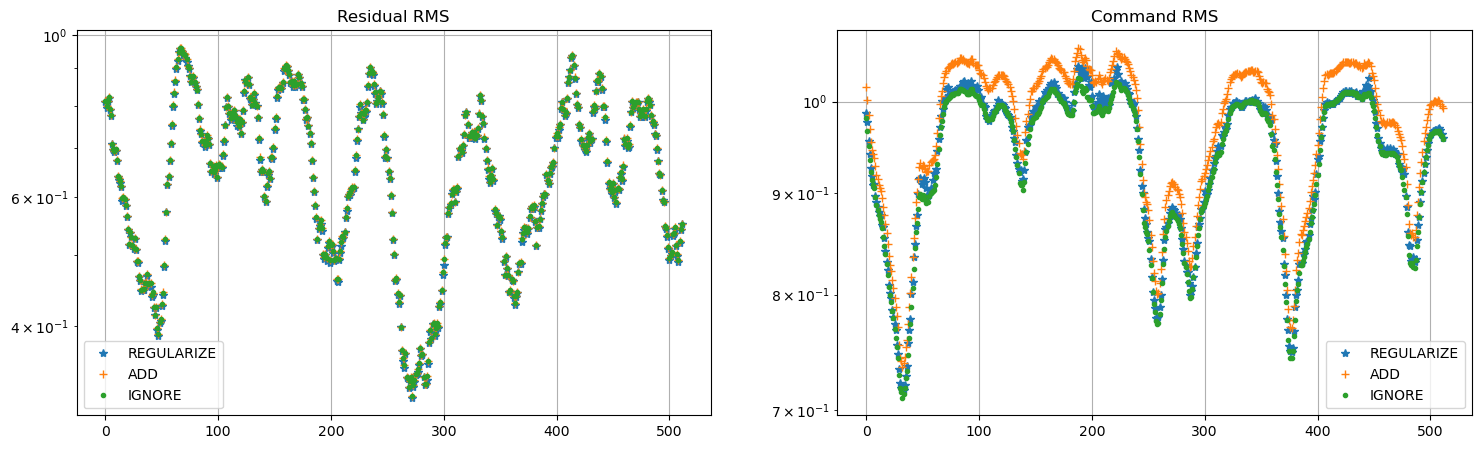

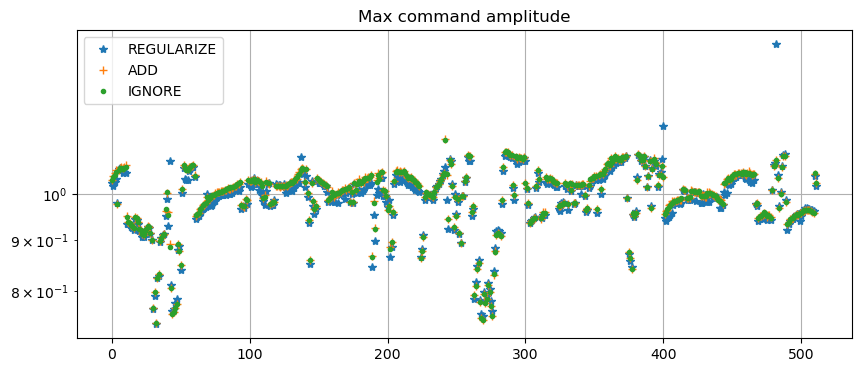

In [28]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(ticho_rms/fa_rms),'*',label='REGULARIZE')
plt.plot(xp.asnumpy(specula_rms/fa_rms),'+',label='ADD')
plt.plot(xp.asnumpy(crop_rms/fa_rms),'.',label='IGNORE')
# plt.plot(xp.asnumpy(mean_rms/fa_rms),'.',label='mean')
plt.legend()
plt.title('Residual RMS')
plt.yscale('log')
plt.grid()
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(ticho_cmd_rms/fa_cmd_rms),'*',label='REGULARIZE')
plt.plot(xp.asnumpy(specula_cmd_rms/fa_cmd_rms),'+',label='ADD')
plt.plot(xp.asnumpy(crop_cmd_rms/fa_cmd_rms),'.',label='IGNORE')
# plt.plot(xp.asnumpy(mean_cmd_rms/fa_cmd_rms),'.',label='mean')
plt.legend()
plt.title('Command RMS')
plt.yscale('log')
plt.grid()

plt.figure(figsize=(10,4))
plt.plot(xp.asnumpy(ticho_max_cmd/fa_max_cmd),'*',label='REGULARIZE')
plt.plot(xp.asnumpy(specula_max_cmd/fa_max_cmd),'+',label='ADD')
plt.plot(xp.asnumpy(crop_max_cmd/fa_max_cmd),'.',label='IGNORE')
plt.legend()
plt.title('Max command amplitude')
plt.yscale('log')
plt.grid()

In [29]:
print(xp.sum(fa_rms)*1e+9,xp.sum(fa_cmd_rms)*1e+9,xp.sum(fa_max_cmd)*1e+9)
print(xp.sum(crop_rms)*1e+9,xp.sum(crop_cmd_rms)*1e+9,xp.sum(crop_max_cmd)*1e+9)
print(xp.sum(mean_rms)*1e+9,xp.sum(mean_cmd_rms)*1e+9,xp.sum(mean_max_cmd)*1e+9)
print(xp.sum(ticho_rms)*1e+9,xp.sum(ticho_cmd_rms)*1e+9,xp.sum(ticho_max_cmd)*1e+9)
print(xp.sum(specula_rms)*1e+9,xp.sum(specula_cmd_rms)*1e+9,xp.sum(specula_max_cmd)*1e+9)

15988.971801661479 138136.79568266487 367337.35931356275
9844.707645839344 129423.73876296308 364175.47178723733
9844.707645839344 129423.73876296308 364175.47178723733
9803.221415201708 130115.57154478476 362093.29077224736
9845.514846303822 134077.52412168682 364202.0100745729
